<h1 align='center' style='color:blue'>Steel Industry Energy Consumption Prediction</h1>

### Load Python Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from xgboost import XGBRegressor, plot_importance
import shap

### Load Data

In [2]:
df = pd.read_csv('steel_industry_data.csv')
df.head(3)

,date,Usage_kWh,Lagging_Current_Reactive.Power_kVarh,Leading_Current_Reactive_Power_kVarh,CO2(tCO2),Lagging_Current_Power_Factor,Leading_Current_Power_Factor,NSM,WeekStatus,Day_of_week,Load_Type
0,01/01/2018 00:15,3.17,2.95,0.0,0.0,73.21,100.0,900,Weekday,Monday,Light_Load
1,01/01/2018 00:30,4.00,4.46,0.0,0.0,66.77,100.0,1800,Weekday,Monday,Light_Load
2,01/01/2018 00:45,3.24,3.28,0.0,0.0,70.28,100.0,2700,Weekday,Monday,Light_Load


In [3]:
df.shape

(35040, 11)

In [4]:
df.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   date                                  35040 non-null  object 
 1   Usage_kWh                             35040 non-null  float64
 2   Lagging_Current_Reactive.Power_kVarh  35040 non-null  float64
 3   Leading_Current_Reactive_Power_kVarh  35040 non-null  float64
 4   CO2(tCO2)                             35040 non-null  float64
 5   Lagging_Current_Power_Factor          35040 non-null  float64
 6   Leading_Current_Power_Factor          35040 non-null  float64
 7   NSM                                   35040 non-null  int64  
 8   WeekStatus                            35040 non-null  object 
 9   Day_of_week                           35040 non-null  object 
 10  Load_Type                             35040 non-null  object 
dtypes: float64(6), 

In [6]:
#Rename the columns for simplicity
df = df.rename(columns={'CO2(tCO2)': 'tco2', 
                        'Lagging_Current_Reactive.Power_kVarh': 'lagging_kvarh', 
                        'Leading_Current_Reactive_Power_kVarh': 'leading_kvarh', 
                       'Lagging_Current_Power_Factor': 'lagging_pf', 
                       'Leading_Current_Power_Factor': 'leading_pf'})

In [7]:
#Change all column names into lowercase
df.columns = df.columns.str.lower() 

In [8]:
# df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y %H:%M', errors='coerce')

### Handle Missing & Duplicate Values

In [9]:
#Check for null values
print("NA values: " , df.isna().sum().sum())
print("Null values: ", df.isnull().sum().sum())
print("Duplicated values: ", df.duplicated().sum().sum())

NA values:  0
Null values:  0
Duplicated values:  0


In [10]:
df.describe()

,usage_kwh,lagging_kvarh,leading_kvarh,tco2,lagging_pf,leading_pf,nsm
count,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000,35040.000000
mean,27.386892,13.035384,3.870949,0.011524,80.578056,84.367870,42750.000000
std,33.444380,16.306000,7.424463,0.016151,18.921322,30.456535,24940.534317
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.200000,2.300000,0.000000,0.000000,63.320000,99.700000,21375.000000
50%,4.570000,5.000000,0.000000,0.000000,87.960000,100.000000,42750.000000
75%,51.237500,22.640000,2.090000,0.020000,99.022500,100.000000,64125.000000
max,157.180000,96.910000,27.760000,0.070000,100.000000,100.000000,85500.000000


In [11]:
df.columns

Index(['date', 'usage_kwh', 'lagging_kvarh', 'leading_kvarh', 'tco2',
       'lagging_pf', 'leading_pf', 'nsm', 'weekstatus', 'day_of_week',
       'load_type'],
      dtype='object')

**Change tCO2 to kgCO2 for better understanding**

In [12]:
#Create new column and drop the old one
df["kgco2"] = df.tco2 * 1000
df.drop('tco2', inplace=True, axis=1)

**Remove the 'nsm' column, representing the Number of Seconds from Midnight**

This column is removed because it doesn’t correlate well with energy usage. While energy varies throughout the day, 'nsm' decreases predictably as midnight approaches, offering little value for modeling.

In [13]:
df.drop('nsm', inplace=True, axis=1)

<h2 style="color:blue" align="center">Exploratory Data Analysis</h2>

In [14]:
columns_continuous = ['usage_kwh', 'lagging_kvarh', 'leading_kvarh', 'kgco2','lagging_pf', 'leading_pf']

columns_categorical = ['weekstatus', 'day_of_week','load_type']

### **Univariate Analysis**

### Distribution of Continuous Columns using Violin Plot

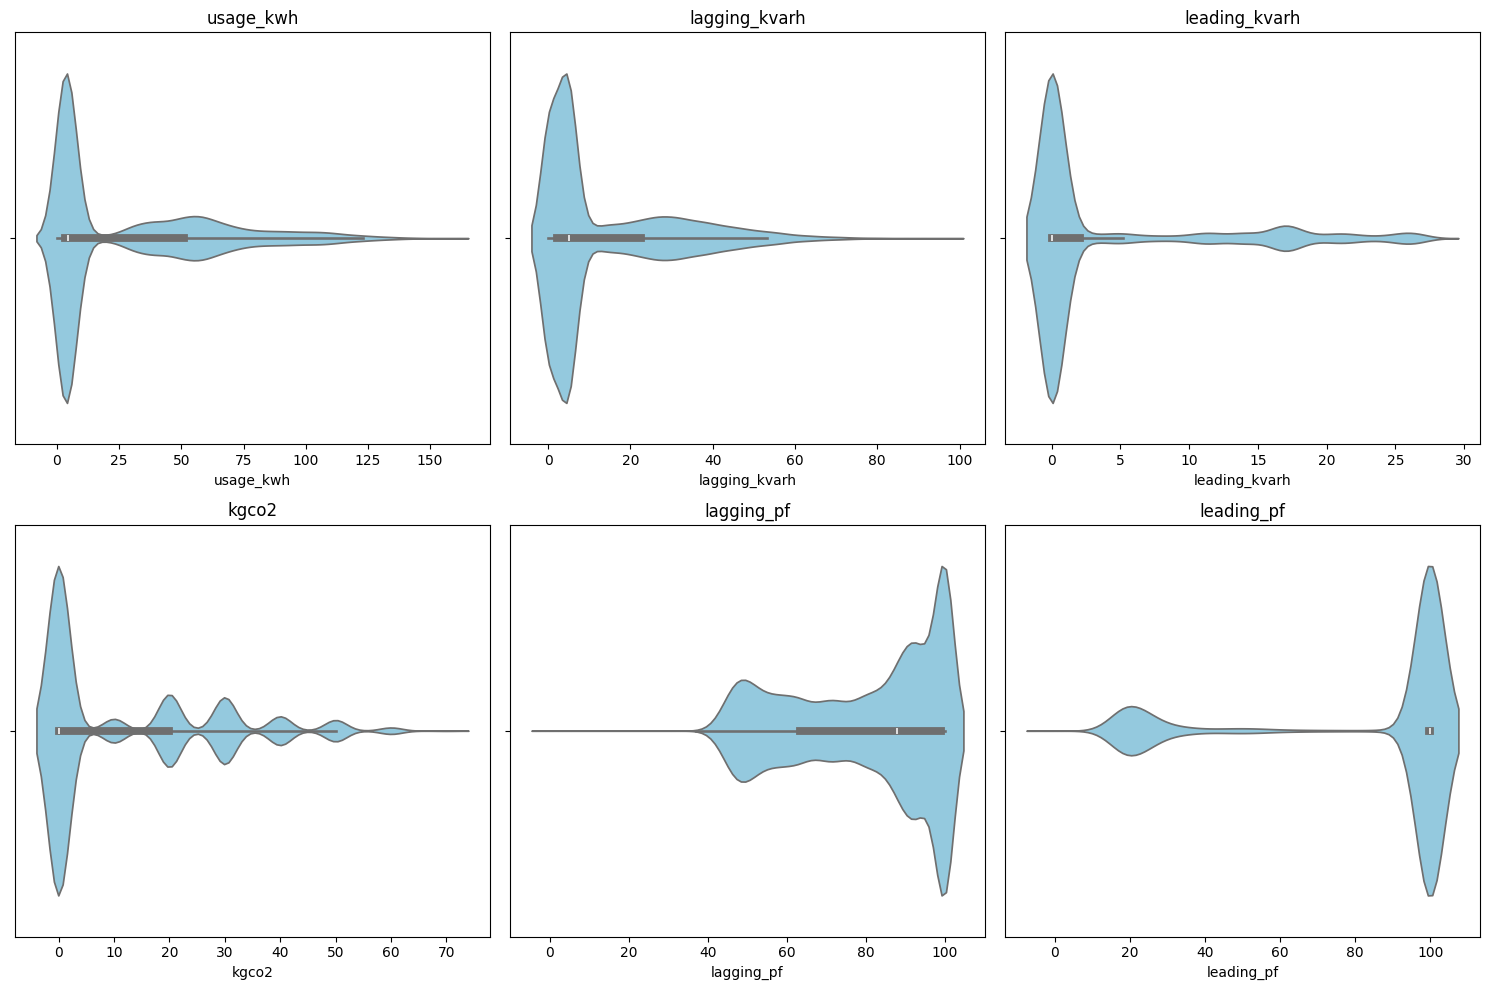

In [15]:
num_plots = len(columns_continuous)
num_cols = 3  # Number of plots per row
num_rows = (num_plots + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))  # Adjust the figure size as needed
axes = axes.flatten()  # Flatten the axes array for easier indexing

for i, col in enumerate(columns_continuous):
    sns.violinplot(x=df[col], ax=axes[i], color='skyblue')  # Using violin plot instead of box plot
    axes[i].set_title(col)  # Set the title to the name of the variable

# If there are any empty plots (if the number of plots isn't a perfect multiple of num_cols), hide the axes
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

**Insight**

The energy distribution plot shows that most values are near 0 kWh, reflecting periods when machinery is off. This isn't an outlier since 0 kWh is a valid measure. Machinery typically runs at nominal levels and rarely at full capacity. Most data falls within the 0 to 50 kWh range, with only a few higher values.

### Analyzing Categorical Columns

In [16]:
columns_categorical

['weekstatus', 'day_of_week', 'load_type']

In [17]:
# Print all unique values for the 3 columns
print(df.weekstatus.value_counts(), "\n")
print(df.day_of_week.value_counts(), "\n")
print(df.load_type.value_counts(), "\n")

weekstatus
Weekday    25056
Weekend     9984
Name: count, dtype: int64 

day_of_week
Monday       5088
Tuesday      4992
Wednesday    4992
Thursday     4992
Friday       4992
Saturday     4992
Sunday       4992
Name: count, dtype: int64 

load_type
Light_Load      18072
Medium_Load      9696
Maximum_Load     7272
Name: count, dtype: int64 



### **Multivariant Analysis**
### Power Factor Analysis

**Question: How do current power factors affect power usage?**

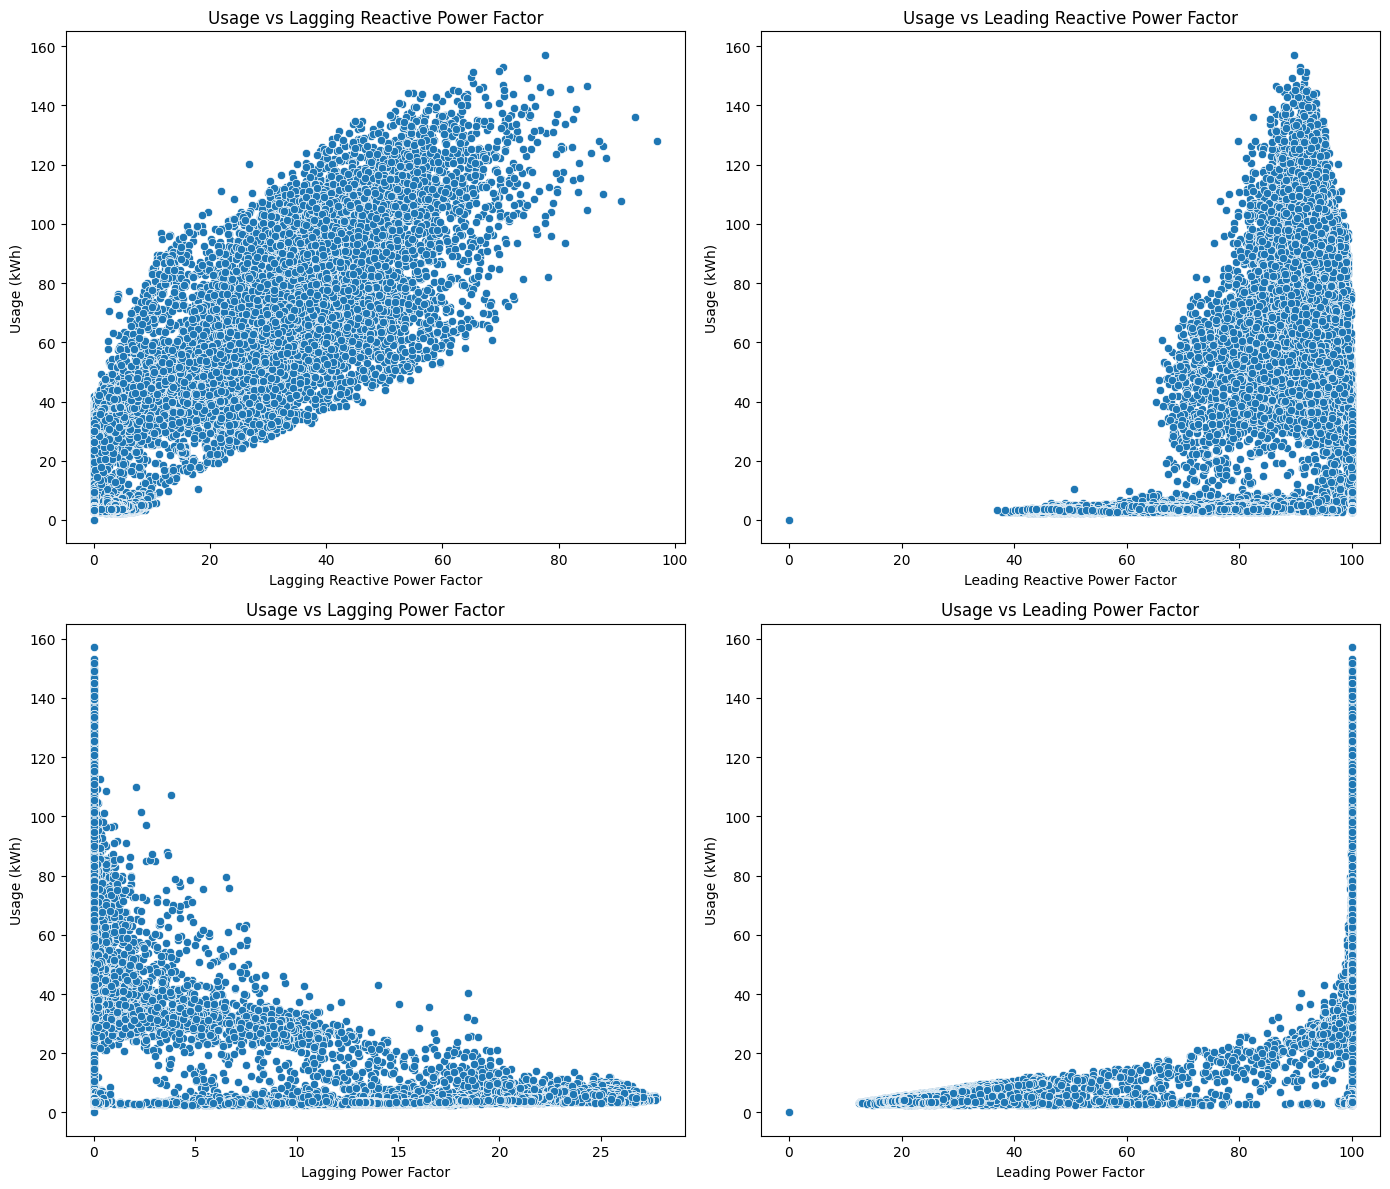

In [18]:
fig, ax = plt.subplots(2, 2, figsize=(14, 12))  # Adjust figsize for better layout

# Scatter plot for Lagging Reactive Power Factor
sns.scatterplot(x='lagging_kvarh', y='usage_kwh', data=df, ax=ax[0, 0])
ax[0, 0].set_title('Usage vs Lagging Reactive Power Factor')
ax[0, 0].set_xlabel('Lagging Reactive Power Factor')
ax[0, 0].set_ylabel('Usage (kWh)')

# Scatter plot for Leading Reactive Power Factor
sns.scatterplot(x='leading_kvarh', y='usage_kwh', data=df, ax=ax[1, 0])
ax[0, 1].set_title('Usage vs Leading Reactive Power Factor')
ax[0, 1].set_xlabel('Leading Reactive Power Factor')
ax[0, 1].set_ylabel('Usage (kWh)')

# Scatter plot for Lagging Power Factor
sns.scatterplot(x='lagging_pf', y='usage_kwh', data=df, ax=ax[0, 1])
ax[1, 0].set_title('Usage vs Lagging Power Factor')
ax[1, 0].set_xlabel('Lagging Power Factor')
ax[1, 0].set_ylabel('Usage (kWh)')

# Scatter plot for Leading Power Factor
sns.scatterplot(x='leading_pf', y='usage_kwh', data=df, ax=ax[1, 1])
ax[1, 1].set_title('Usage vs Leading Power Factor')
ax[1, 1].set_xlabel('Leading Power Factor')
ax[1, 1].set_ylabel('Usage (kWh)')

# Adjust layout to make room for labels
plt.tight_layout()

# Show the plots
plt.show()


**Insight**

### Day of Week and Week Status Analysis

**Question: What are the power usage patterns across different days of the week and week statuses?**

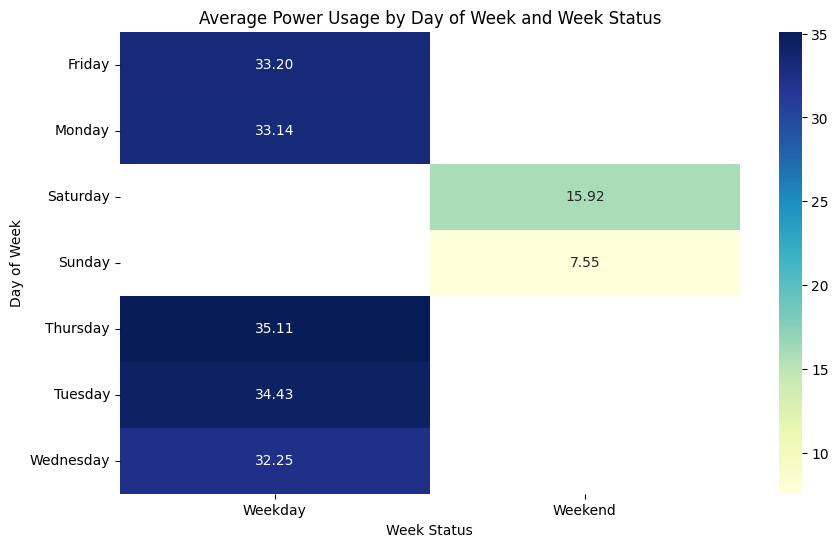

In [19]:
# Group by Day_of_week and WeekStatus and calculate mean usage
usage_by_day_week = df.groupby(['day_of_week', 'weekstatus'])['usage_kwh'].mean().unstack()

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(usage_by_day_week, annot=True, cmap='YlGnBu', cbar=True, fmt='.2f')
plt.title('Average Power Usage by Day of Week and Week Status')
plt.xlabel('Week Status')
plt.ylabel('Day of Week')
plt.show()

**Insight:** The heatmap analysis indicates that power usage is generally higher during weekdays compared to weekends, this pattern reflects typical usage behavior, with higher consumption during business days and reduced usage during weekends.

### Usage Trends and Patterns

**Question: What are the trends in power usage over time?**

In [20]:
# Extract month, year, day, hour from dat column
df_date = df

df['month'] = df.date.str[3:5]
df['year'] = df.date.str[6:10]
df['day'] = df.date.str[0:2]
df['hour'] = df.date.str[11:13]

In [21]:
df.year.value_counts() # Only 2018 recorded, so year is not needed

year
2018    35040
Name: count, dtype: int64

In [22]:
df.drop(['date', 'year'], inplace=True, axis=1)  # Drop date and year columns

In [23]:
#Dictionary to replace numeric values of months for string values
months_dict = {'01':'jan', '02':'feb', '03':'mar','04':'apr', '05':'may', '06': 'jun', '07': 'jul', 
              '08': 'aug', '09': 'sept', '10': 'oct', '11': 'nov', '12': 'dec'}
df.month = df.month.replace(months_dict)

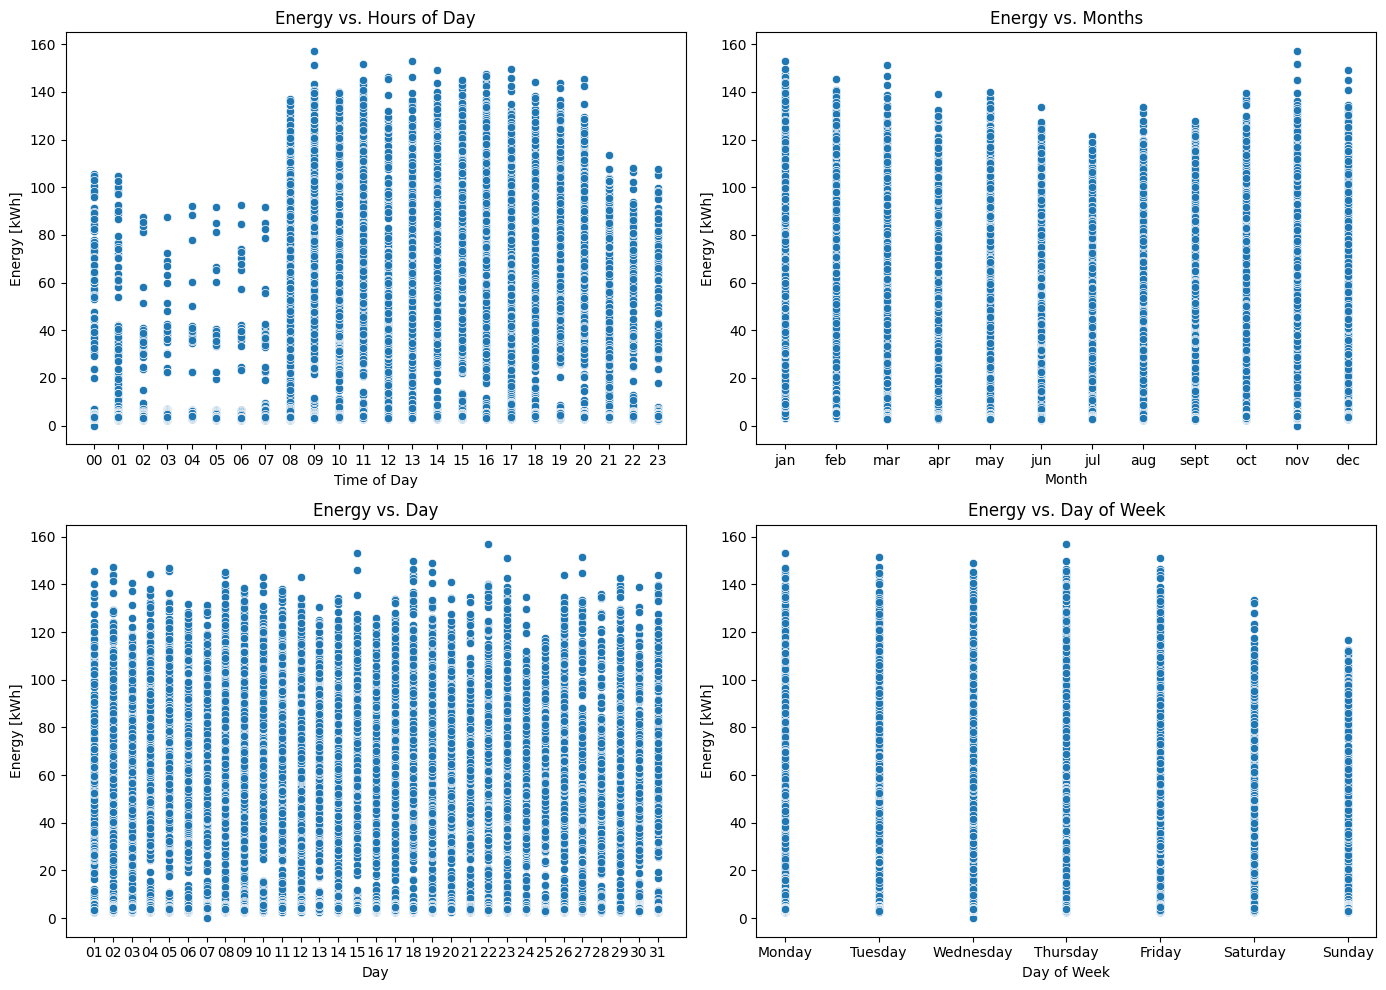

In [24]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Energy vs. Hours of day
sns.scatterplot(x=df['hour'], y=df['usage_kwh'], ax=axes[0, 0])
axes[0, 0].set_title("Energy vs. Hours of Day")
axes[0, 0].set_xlabel("Time of Day")
axes[0, 0].set_ylabel("Energy [kWh]")

# Plot 2: Energy vs. Months
sns.scatterplot(x=df['month'], y=df['usage_kwh'], ax=axes[0, 1])
axes[0, 1].set_title("Energy vs. Months")
axes[0, 1].set_xlabel("Month")
axes[0, 1].set_ylabel("Energy [kWh]")

# Plot 3: Energy vs. Day
sns.scatterplot(x=df['day'], y=df['usage_kwh'], ax=axes[1, 0])
axes[1, 0].set_title("Energy vs. Day")
axes[1, 0].set_xlabel("Day")
axes[1, 0].set_ylabel("Energy [kWh]")

# Plot 4: Energy vs. Day of Week
sns.scatterplot(x=df['day_of_week'], y=df['usage_kwh'], ax=axes[1, 1])
axes[1, 1].set_title("Energy vs. Day of Week")
axes[1, 1].set_xlabel("Day of Week")
axes[1, 1].set_ylabel("Energy [kWh]")

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Insights**

- The data predominantly clusters around typical business hours, which appear to be from 8 a.m. to 8 p.m.
  
- Monthly variations in energy usage are minimal, suggesting that the month is unlikely to be a significant predictor. Thus, this feature will be excluded from the model.
  
- The 'day' of the month does not significantly impact energy consumption. The factory's production levels remain consistent throughout the month, showing no notable fluctuations on specific days.
Given that the 'day' feature does not add significant value and we already have 'Weekstatus' and 'day_of_week' columns, the 'day' feature will be removed.

In [25]:
df.drop(['day', 'month'], inplace=True, axis=1)

<h2 style="color:blue" align="center">Feature Engineering</h2>

In [26]:
df.head(2)

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,weekstatus,day_of_week,load_type,kgco2,hour
0,3.17,2.95,0.0,73.21,100.0,Weekday,Monday,Light_Load,0.0,00
1,4.00,4.46,0.0,66.77,100.0,Weekday,Monday,Light_Load,0.0,00


### Encode Text Columns

**Handle nomical column**

Weekstatus, day_of_week and load_type has all text data. It needs to be converted to numbers and we will use dummy variable for that

In [27]:
# Select all the categorical columns
categorical = df.select_dtypes(include='object').columns

# Create dummy variables without prefixes
df1 = pd.get_dummies(df, columns=categorical, drop_first=True, dtype=int, prefix='')

# Remove leading underscores and convert column names to lowercase
df1.columns = df1.columns.str.lstrip('_').str.lower()

# Display the first 3 rows of the resulting DataFrame
df1.head(3)


,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,monday,saturday,sunday,...,14,15,16,17,18,19,20,21,22,23
0,3.17,2.95,0.0,73.21,100.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.00,4.46,0.0,66.77,100.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.24,3.28,0.0,70.28,100.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35040 entries, 0 to 35039
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   usage_kwh      35040 non-null  float64
 1   lagging_kvarh  35040 non-null  float64
 2   leading_kvarh  35040 non-null  float64
 3   lagging_pf     35040 non-null  float64
 4   leading_pf     35040 non-null  float64
 5   kgco2          35040 non-null  float64
 6   weekend        35040 non-null  int64  
 7   monday         35040 non-null  int64  
 8   saturday       35040 non-null  int64  
 9   sunday         35040 non-null  int64  
 10  thursday       35040 non-null  int64  
 11  tuesday        35040 non-null  int64  
 12  wednesday      35040 non-null  int64  
 13  maximum_load   35040 non-null  int64  
 14  medium_load    35040 non-null  int64  
 15  01             35040 non-null  int64  
 16  02             35040 non-null  int64  
 17  03             35040 non-null  int64  
 18  04    

### Feature Selection

In [29]:
df1.head(3)                

,usage_kwh,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,monday,saturday,sunday,...,14,15,16,17,18,19,20,21,22,23
0,3.17,2.95,0.0,73.21,100.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4.00,4.46,0.0,66.77,100.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3.24,3.28,0.0,70.28,100.0,0.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
df1.columns

Index(['usage_kwh', 'lagging_kvarh', 'leading_kvarh', 'lagging_pf',
       'leading_pf', 'kgco2', 'weekend', 'monday', 'saturday', 'sunday',
       'thursday', 'tuesday', 'wednesday', 'maximum_load', 'medium_load', '01',
       '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13',
       '14', '15', '16', '17', '18', '19', '20', '21', '22', '23'],
      dtype='object')

#### Correlation Heatmap with Target

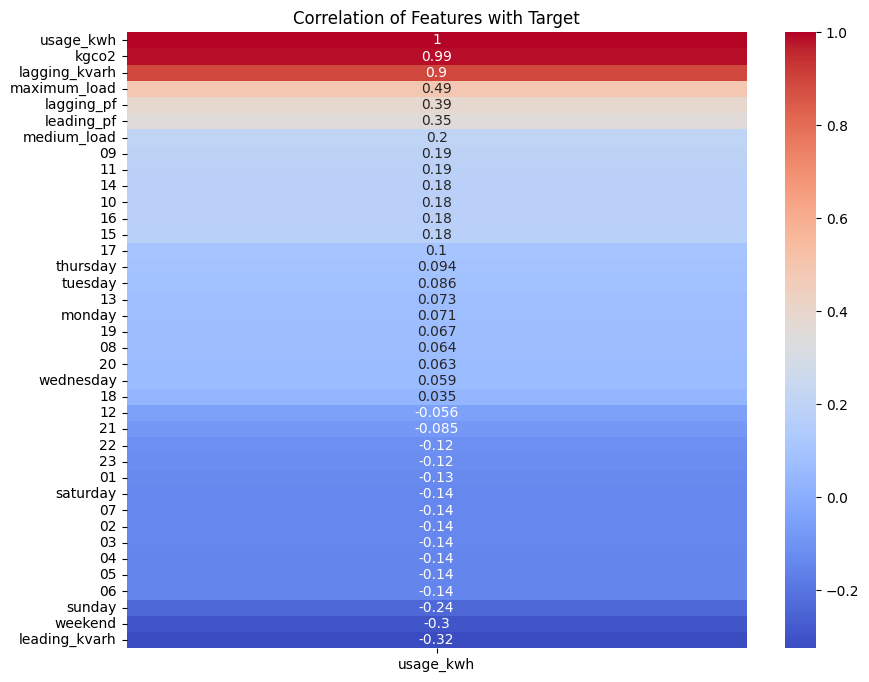

In [31]:
corr = df1.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['usage_kwh']].sort_values(by='usage_kwh', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlation of Features with Target')
plt.show()

There are very few features that have good correlation, I'll only select the ones above 0.20. 

In [32]:
corr_usage = abs(corr["usage_kwh"]) 
selected_features = corr_usage[corr_usage > 0.2].index.drop("usage_kwh")
selected_features

Index(['lagging_kvarh', 'leading_kvarh', 'lagging_pf', 'leading_pf', 'kgco2',
       'weekend', 'sunday', 'maximum_load', 'medium_load'],
      dtype='object')

In [33]:
# Define the feature matrix X and the target vector y
X = df1[selected_features]
y = df1['usage_kwh']

# List of columns to be scaled
cols_to_scale = ['lagging_kvarh', 'leading_kvarh', 'kgco2', 'lagging_pf', 'leading_pf']

# Initialize the scaler
scaler = StandardScaler()

# Apply scaling using .loc to avoid SettingWithCopyWarning
X.loc[:, cols_to_scale] = scaler.fit_transform(X[cols_to_scale])

# Display the scaled features
X.describe()


,lagging_kvarh,leading_kvarh,lagging_pf,leading_pf,kgco2,weekend,sunday,maximum_load,medium_load
count,3.504000e+04,3.504000e+04,3.504000e+04,3.504000e+04,3.504000e+04,35040.000000,35040.000000,35040.000000,35040.000000
mean,-7.137872e-17,6.488975e-18,-4.801841e-16,-3.601381e-16,-1.168015e-16,0.284932,0.142466,0.207534,0.276712
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00,0.451388,0.349532,0.405547,0.447379
min,-7.994339e-01,-5.213850e-01,-4.258646e+00,-2.770147e+00,-7.135502e-01,0.000000,0.000000,0.000000,0.000000
25%,-6.583795e-01,-5.213850e-01,-9.121087e-01,5.034174e-01,-7.135502e-01,0.000000,0.000000,0.000000,0.000000
50%,-4.927940e-01,-5.213850e-01,3.901445e-01,5.132676e-01,-7.135502e-01,0.000000,0.000000,0.000000,0.000000
75%,5.890319e-01,-2.398792e-01,9.748107e-01,5.132676e-01,5.247945e-01,1.000000,0.000000,0.000000,1.000000
max,5.143862e+00,3.217659e+00,1.026473e+00,5.132676e-01,3.620656e+00,1.000000,1.000000,1.000000,1.000000


<h2 align="center" style="color:blue">Model Training and Evaluation</h2>

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# shape of the X_train, X_test, y_train, y_test features
print("x train: ",X_train.shape)
print("x test: ",X_test.shape)
print("y train: ",y_train.shape)
print("y test: ",y_test.shape)

x train:  (28032, 9)
x test:  (7008, 9)
y train:  (28032,)
y test:  (7008,)


In [35]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1),
    "Lasso Regression": Lasso(alpha=0.1),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=50, max_depth=4, random_state=42)
}

# Dictionary to store evaluation metrics
results = {}

for name, model in models.items():
    # Fit the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # Evaluate the model
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test = np.sqrt(mse_test)
    r2_train = r2_score(y_train, y_pred_train)
    r2_test = r2_score(y_test, y_pred_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    
    # Store the results
    results[name] = {
        'Train RMSE': rmse_train,
        'Test RMSE': rmse_test,
        'Train R^2': r2_train,
        'Test R^2': r2_test,
        'Train MAE': mae_train,
        'Test MAE': mae_test
    }
    
    print(f"{name} ==> Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}, "
          f"Train R^2: {r2_train:.3f}, Test R^2: {r2_test:.3f}, "
          f"Train MAE: {mae_train:.3f}, Test MAE: {mae_test:.3f}")


Linear Regression ==> Train RMSE: 4.751, Test RMSE: 4.404, Train R^2: 0.980, Test R^2: 0.983, Train MAE: 2.578, Test MAE: 2.523
Ridge Regression ==> Train RMSE: 4.751, Test RMSE: 4.405, Train R^2: 0.980, Test R^2: 0.983, Train MAE: 2.579, Test MAE: 2.523
Lasso Regression ==> Train RMSE: 4.780, Test RMSE: 4.411, Train R^2: 0.980, Test R^2: 0.983, Train MAE: 2.571, Test MAE: 2.504
Random Forest ==> Train RMSE: 0.340, Test RMSE: 0.740, Train R^2: 1.000, Test R^2: 1.000, Train MAE: 0.096, Test MAE: 0.240
Gradient Boosting ==> Train RMSE: 2.849, Test RMSE: 2.861, Train R^2: 0.993, Test R^2: 0.993, Train MAE: 1.746, Test MAE: 1.744
XGBoost ==> Train RMSE: 1.941, Test RMSE: 1.988, Train R^2: 0.997, Test R^2: 0.996, Train MAE: 1.115, Test MAE: 1.144


In [36]:
# Convert the results dictionary to a DataFrame for easy comparison
results_df = pd.DataFrame(results).T  # Transpose to get models as rows and metrics as columns

# Display the DataFrame
results_df

,Train RMSE,Test RMSE,Train R^2,Test R^2,Train MAE,Test MAE
Linear Regression,4.750788,4.404355,0.979792,0.982756,2.578305,2.522858
Ridge Regression,4.750789,4.404549,0.979792,0.982755,2.578759,2.523357
Lasso Regression,4.780477,4.410925,0.979539,0.982705,2.571194,2.504481
Random Forest,0.340087,0.739752,0.999896,0.999514,0.095892,0.240392
Gradient Boosting,2.849033,2.860970,0.992732,0.992724,1.745756,1.744480
XGBoost,1.941498,1.987928,0.996625,0.996487,1.115104,1.144160


**Bar plot visual for Train and Test RMSE by Selected Model**

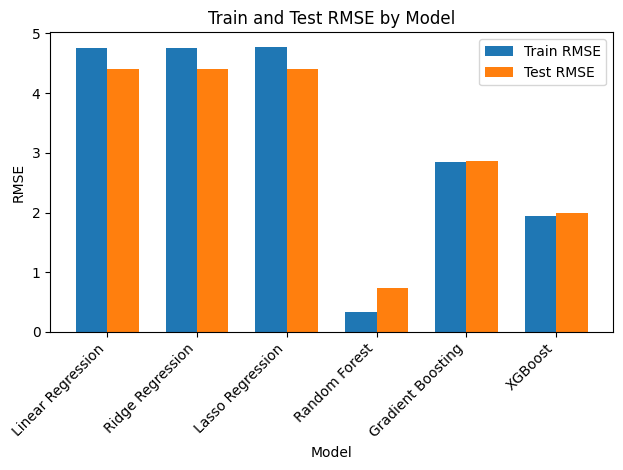

In [37]:
models_list = list(results.keys())
train_rmse = [results[model]['Train RMSE'] for model in models_list]
test_rmse = [results[model]['Test RMSE'] for model in models_list]

x = np.arange(len(models_list))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, train_rmse, width, label='Train RMSE')
bars2 = ax.bar(x + width/2, test_rmse, width, label='Test RMSE')

ax.set_xlabel('Model')
ax.set_ylabel('RMSE')
ax.set_title('Train and Test RMSE by Model')
ax.set_xticks(x)
ax.set_xticklabels(models_list, rotation=45, ha='right')
ax.legend()

plt.tight_layout()
plt.show()


**Line plot visual for Train and Test R2 by Selected Model**

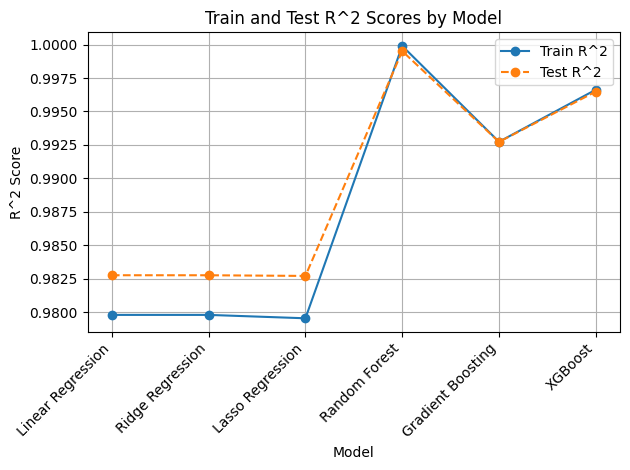

In [38]:
r2_train = [results[model]['Train R^2'] for model in models_list]
r2_test = [results[model]['Test R^2'] for model in models_list]

fig, ax = plt.subplots()
ax.plot(models_list, r2_train, marker='o', linestyle='-', label='Train R^2')
ax.plot(models_list, r2_test, marker='o', linestyle='--', label='Test R^2')

ax.set_xlabel('Model')
ax.set_ylabel('R^2 Score')
ax.set_title('Train and Test R^2 Scores by Model')
ax.legend()
ax.grid(True)

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


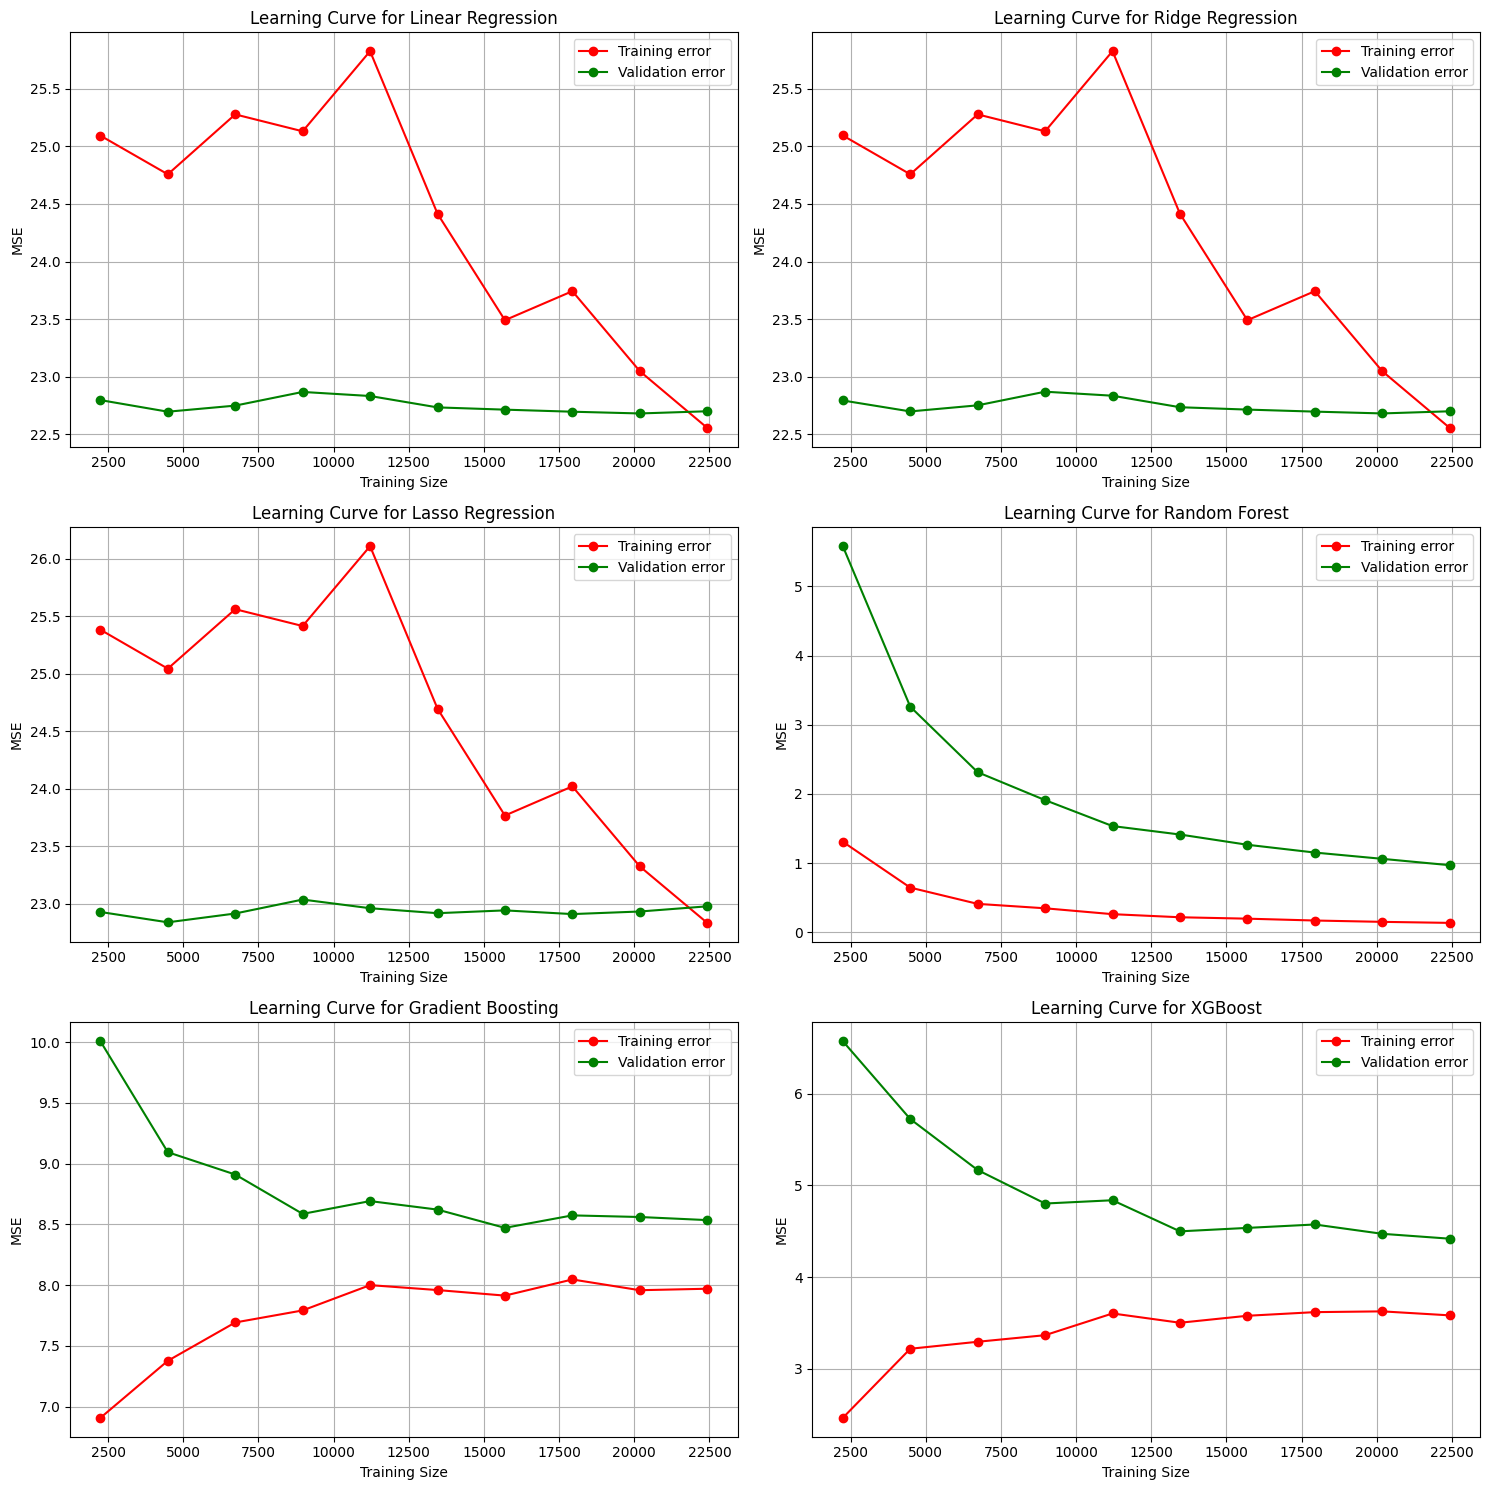

In [39]:
def plot_learning_curve(ax, model, title, X, y):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=np.linspace(0.1, 1.0, 10), cv=5, n_jobs=-1, scoring='neg_mean_squared_error'
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    validation_scores_mean = -np.mean(validation_scores, axis=1)
    
    ax.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training error')
    ax.plot(train_sizes, validation_scores_mean, 'o-', color='g', label='Validation error')

    ax.set_title(title)
    ax.set_xlabel('Training Size')
    ax.set_ylabel('MSE')
    ax.legend(loc='best')
    ax.grid()

# Create a 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()  # Flatten the 2D array of axes to iterate easily

models_list = list(models.items())  # List of tuples (name, model)
for i, (name, model) in enumerate(models_list):
    plot_learning_curve(axs[i], model, f'Learning Curve for {name}', X_train, y_train)

# Hide any unused subplots (if fewer than 6 models)
for j in range(len(models_list), len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.show()


<h2 align="center" style="color:blue">Model Interpretation</h2>

Based on the evaluation metrics provided, we can analyze the performance of the models and discuss the justification for selecting the best model for predicting usage_kwh.

Given the results:
- Random Forest has the best performance in terms of RMSE and R², but the almost perfect train R² suggests overfitting. This might make it less reliable in scenarios where the test data could vary more from the training data.
  
- XGBoost provides excellent performance with a lower risk of overfitting compared to Random Forest. The slightly higher RMSE than Random Forest is offset by better generalization.
  
- Gradient Boosting also performs well but is outperformed by XGBoost in both RMSE and R².

**Justification**:
- XGBoost is the most balanced model, offering strong predictive performance with lower risk of overfitting. Its ability to generalize well makes it the best choice for predicting usage_kwh. It captures the complexities in the data while maintaining robustness across different data splits, which is critical in real-world applications where the test data may vary from the training data.

- While Random Forest performs exceptionally well, its overfitting risk makes it less reliable for generalization, which is crucial for predictive modeling.

<Figure size 1000x800 with 0 Axes>

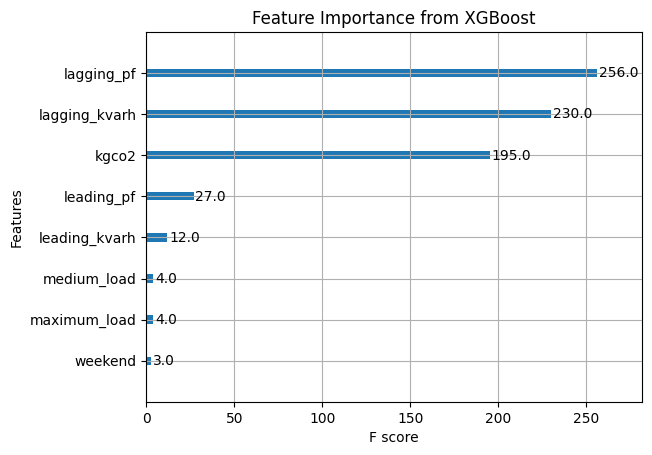

In [40]:
model_xgb = models['XGBoost']

# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(model_xgb, importance_type='weight')  # 'weight' is the number of times a feature appears in trees across the ensemble.
plt.title('Feature Importance from XGBoost')
plt.show()

**Insights**

- Lagging Reactive Power [kvarh]: This feature shows a high importance score, indicating that it is a key predictor in the model. Features with high positive importance scores contribute significantly to the model's predictions.

- Power Factor: This feature also has substantial importance, reflecting its significant role in predicting the target variable. Features with notable importance values have a direct impact on the model’s accuracy.

#### Residual Plot and Prediction Error Plot for XGBoost 

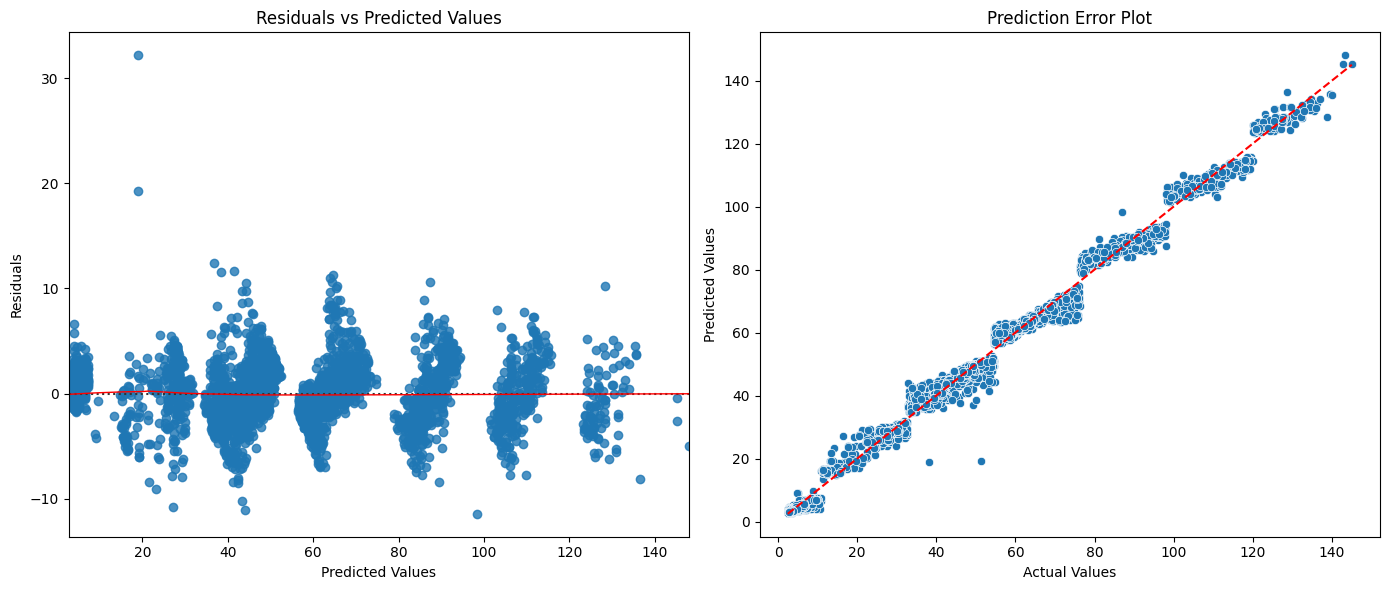

In [41]:
# Residual plot for XGBoost
y_pred = model_xgb.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(14, 6))

# Residual Plot
plt.subplot(1, 2, 1)
sns.residplot(x=y_pred, y=residuals, lowess=True, line_kws={'color': 'r', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')

# Prediction Error Plot
plt.subplot(1, 2, 2)
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Prediction Error Plot')

plt.tight_layout()
plt.show()

In [42]:
residuals_pct = (residuals / y_test) * 100

# Create DataFrame for residuals and prediction errors
residuals_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'difference': residuals,
    'difference_pct': residuals_pct
})

# Display the first few rows of the DataFrame
residuals_df.head()

,actual,predicted,difference,difference_pct
5467,5.76,4.666786,1.093214,18.979415
8443,3.53,3.673169,-0.143169,-4.055776
28433,3.20,3.160215,0.039785,1.243292
19894,2.84,3.094297,-0.254297,-8.954109
4436,3.06,3.735393,-0.675393,-22.071668


In [43]:
# Define threshold for extreme errors
extreme_error_threshold = 10  # Adjust based on your requirements

# Filter results with extreme errors
extreme_results_df = residuals_df[np.abs(residuals_df['difference_pct']) > extreme_error_threshold]
extreme_results_df.head()

,actual,predicted,difference,difference_pct
5467,5.76,4.666786,1.093214,18.979415
4436,3.06,3.735393,-0.675393,-22.071668
31228,3.06,3.803519,-0.743519,-24.298022
11644,2.92,3.244936,-0.324936,-11.127961
5094,6.44,4.388893,2.051107,31.849493


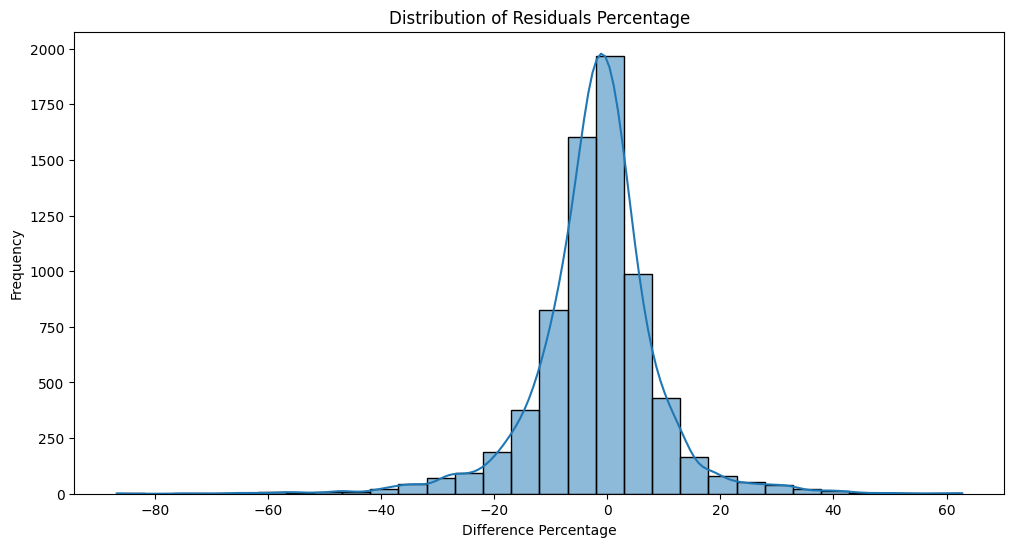

In [44]:
# Plot histogram of residuals percentage
plt.figure(figsize=(12, 6))
sns.histplot(residuals_df['difference_pct'], kde=True, bins=30)
plt.title('Distribution of Residuals Percentage')
plt.xlabel('Difference Percentage')
plt.ylabel('Frequency')
plt.show()

In [45]:
extreme_results_df.shape

(1669, 4)

In [46]:
extreme_errors_pct = extreme_results_df.shape[0]*100/X_test.shape[0]
extreme_errors_pct

23.815639269406393

**We observe that 21% of predictions deviate by 10% or more from the actual power usage, indicating overestimation or underestimation**

In [47]:
extreme_results_df[abs(extreme_results_df.difference_pct)>25].sort_values("difference_pct",ascending=False)

,actual,predicted,difference,difference_pct
133,51.26,19.088665,32.171335,62.761091
14352,10.62,4.057862,6.562138,61.790374
2815,9.68,3.970115,5.709885,58.986411
7672,8.42,3.928112,4.491888,53.347844
175,38.16,18.948219,19.211781,50.345337
...,...,...,...,...
17064,14.15,23.259680,-9.109680,-64.379363
29256,16.31,27.074696,-10.764696,-66.000586
22936,2.70,4.515443,-1.815443,-67.238624
30328,5.15,8.999699,-3.849699,-74.751430


**Approximately 301 power usage predictions deviate by over 25% from the actual values**